# Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, VilBertVisualBertModel
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, DefinedColorJitter, DefinedRandomPerspective
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.0, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.4, "half_cut":0.1}
preprocess_text = TextAugment([0.0, 0.1, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

im_transform = ImageAugment(count_proba=[0.1, 0.9], 
                            augs_dict=dict(grayscale=transforms.Grayscale(num_output_channels=3), 
                                           hflip=transforms.RandomHorizontalFlip(p=1.0),
                                           rc2=transforms.Compose([transforms.Resize(480), transforms.CenterCrop(400)]),
                                           rotate=DefinedRotation(15), 
                                           # qcut=QuadrantCut(),
                                           affine=DefinedAffine(0, scale=(0.6, 0.6)),
                                          ),
                            choice_probas="uniform"
                           )


# im_transform = ImageAugment(count_proba=[0.2, 0.8], 
#                             augs_dict=dict(grayscale=transforms.Grayscale(num_output_channels=3), 
#                                            hflip=transforms.RandomHorizontalFlip(p=1.0),
#                                            rc1=transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)]),
#                                            rc2=transforms.Compose([transforms.Resize(480), transforms.CenterCrop(400)]),
#                                            rotate=DefinedRotation(15), 
#                                            qcut=QuadrantCut(),
#                                            affine=DefinedAffine(0, translate=(0.2, 0.2), scale=(0.6, 0.8), shear=(10, 10)),
#                                            jitter=DefinedColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#                                            perspective=DefinedRandomPerspective(0.2)
#                                           ),
#                             choice_probas="uniform"
#                            )

# im_transform = transforms.RandomChoice([transforms.Grayscale(num_output_channels=3), 
#                                         transforms.RandomHorizontalFlip(p=1.0),
#                                         lambda x: x,
#                                         transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)]),
#                                         transforms.Compose([transforms.Resize(480), transforms.CenterCrop(400)]),
#                                         transforms.Compose([transforms.Resize(640), transforms.CenterCrop(520)]),
#                                         DefinedRotation(15), QuadrantCut(), 
#                                         DefinedAffine(0, translate=(0.2, 0.2), scale=(0.6, 0.8), shear=(5, 5)),
#                                         DefinedColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#                                         DefinedRandomPerspective(0.2)])

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=im_transform, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = True, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# ImageAugment([0.2, 0.5, 0.3])


In [3]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2,
                  momentum=0.9,
                  dampening=0,
                  weight_decay=0,
                  nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,
)

adam = torch.optim.Adam
adam_params = params = dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,
)

qhadam = optim.QHAdam
qhadam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,
)

radam = optim.RAdam
radam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
)

yogi = optim.Yogi
yogi_params = dict(lr=1e-2,
                   betas=(0.9, 0.999),
                   eps=1e-3,
                   initial_accumulator=1e-6,
                   weight_decay=0)

In [4]:
batch_size=96
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([5, 7, 10, 17], gamma=0.1) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()




# Single Models

## LXMERT

In [ ]:
lr_strategy = {
    "lxmert": {
        "model": {
            "bert": {
                "encoder": {
                    "x_layers": {
                        "lr": optimizer_params["lr"] / 1e1,
                        "finetune": True
                    },
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "pooler": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
            },
            "finetune": False
        }
    }
}

In [ ]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel

model_fn = model_builder(VilBertVisualBertModel,
                         dict(model_name={"lxmert": dict(dropout=0.15, gaussian_noise=0.15)},
                              num_classes=2,
                              gaussian_noise=2.0,
                              dropout=0.15,
                              word_masking_proba=0.15,
                              featurizer="transformer",
                              final_layer_builder=fb_1d_loss_builder,
                              internal_dims=512,
                              classifier_dims=256,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              n_layers=2,
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


In [ ]:
batch_size=128
epochs = 5

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[2, 7, 9, 11, 14, 17, 19],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=2,
)
r1, p1 = results, prfs
results
prfs


## Visual BERT / VilBert/MMBT Region

In [ ]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
lr_strategy = {
    "mmbt_region": {
        "model": {
            "bert": {
                "mmbt": {
                    "transformer": {
                        "pooler": {
                            "lr": optimizer_params["lr"] / 1e1,
                            "finetune": True
                        }
                    }
                }
            }
        },
        "finetune": False
    }
}
epochs = 3
batch_size = 80
model_fn = model_builder(VilBertVisualBertModel,
                         dict(
                             model_name={"mmbt_region": dict(gaussian_noise=0.0, dropout=0.0)},
                             num_classes=2,
                             gaussian_noise=0.0,
                             dropout=0.0,
                             word_masking_proba=0.0,
                             featurizer="pass",
                             final_layer_builder=fb_1d_loss_builder,
                             internal_dims=256,
                             classifier_dims=768,
                             n_tokens_in=96,
                             n_tokens_out=16,
                             n_layers=2,
                             loss="focal",
                             dice_loss_coef=0.0,
                             auc_loss_coef=0.0,
                         ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 1h 45m
# 4m 49s

Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


N tokens Out =  196
[WARNING]: Perform finetuning on model since num classes = 2 and featurizer_type = `pass`
Autocast =  True Epochs =  2 Divisor = 1 Examples = 7200 Batch Size =  64
Training Samples =  7200 Weighted Sampling =  False Num Batches =  113 Accumulation steps =  1



Epoch =  1 Loss = 0.671270 LR = 0.00008073



Epoch =  2 Loss = 0.660928 LR = 0.00000000



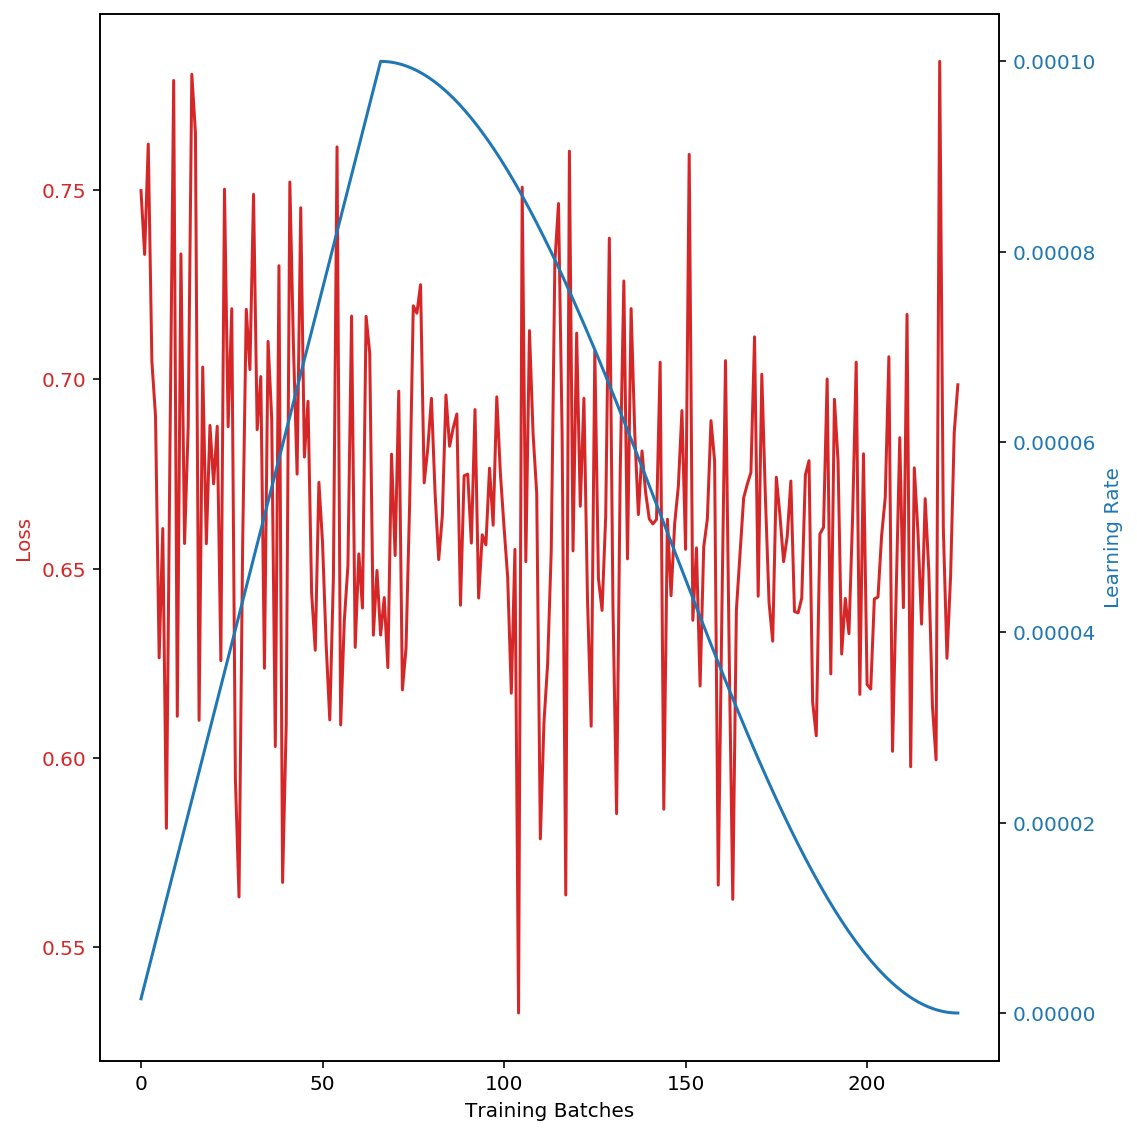

Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.359  0.359 0.354 0.362       0.000  0.000 0.000 0.000
1.000        0.359  0.359 0.355 0.363       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
226,0.358,0.000,0.000
1221,0.360,0.000,1.000
624,0.358,0.000,1.000
400,0.360,0.000,0.000
504,0.360,0.000,0.000
941,0.357,0.000,0.000
203,0.361,0.000,1.000
726,0.358,0.000,0.000
239,0.360,0.000,0.000
681,0.357,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.359  0.359 0.353 0.363       0.000  0.000 0.000 0.000
1.000        0.359  0.359 0.353 0.364       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
3785,0.357,0.000,0.000
4868,0.358,0.000,0.000
5945,0.361,0.000,1.000
6133,0.358,0.000,0.000
2511,0.359,0.000,0.000
2548,0.359,0.000,1.000
2402,0.360,0.000,1.000
4131,0.357,0.000,0.000
1478,0.358,0.000,0.000
2593,0.360,0.000,0.000


train   val
mean_or_std metric               
mean        map       0.484 0.448
            accuracy  0.633 0.633
            auc       0.628 0.586
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.633  1.000 0.776 4560.000     0.633  1.000 0.776 1140.000
pos     0.000  0.000 0.000 2640.000     0.000  0.000 0.000  660.000

In [12]:
adam = torch.optim.Adam
adam_params = params = dict(lr=1e-4, weight_decay=1e-3)
optimizer = adam
optimizer_params = adam_params

from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
lr_strategy = {
    "vilbert": {
        "lr": optimizer_params["lr"] / 10,
        "model": {
            "bert": {
                "t_pooler": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "v_pooler": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            },
            "classifier": {
                "lr": optimizer_params["lr"],
                "finetune": True
            }
        },
        "finetune": True
    }
}
epochs = 2
batch_size = 64
model_fn = model_builder(
    VilBertVisualBertModel,
    dict(
        model_name={"vilbert": dict(gaussian_noise=0.0, dropout=0.0)},
        num_classes=2,
        gaussian_noise=0.0,
        dropout=0.0,
        word_masking_proba=0.0,
        featurizer="pass",
        final_layer_builder=fb_1d_loss_builder,
        internal_dims=256,
        classifier_dims=768,
        n_tokens_in=96,
        n_tokens_out=16,
        n_layers=2,
        loss="classification",
        dice_loss_coef=0.0,
        auc_loss_coef=0.0,
    ),
    per_param_opts_fn=lr_strategy,
    optimiser_class=optimizer,
    optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    show_model_stats=False,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 1h 45m
# 4m 49s

# Triple Bert Pooled

In [ ]:
batch_size = 32
epochs = 10
lr_strategy = {
    "lxmert": {
        "lr": optimizer_params["lr"] / 100
    },
}

from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel

model_fn = model_builder(VilBertVisualBertModel,
                         dict(
                             model_name=["vilbert", "lxmert", "visual_bert"],
                             num_classes=2,
                             gaussian_noise=0.1,
                             dropout=0.35,
                             featurizer="pass",
                             final_layer_builder=fb_1d_loss_builder,
                             internal_dims=None,
                             classifier_dims=768,
                             n_tokens_out=96 + 100 + 96 + 36 + 96 + 100,
                             n_tokens_in=96,
                             n_layers=2,
                             task="classification",
                             finetune_vilbert=False,
                             finetune_lxmert=True,
                             finetune_visual_bert=False,
                         ),
                         per_param_opts_fn=None,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

# 1h 45m

In [ ]:

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19], 
    show_model_stats=True)
r1, p1 = results, prfs
results
prfs


# Triple Bert Transformer

In [ ]:
batch_size=32
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel

model_fn = model_builder(VilBertVisualBertModel, 
                         dict(model_name=["vilbert", "lxmert", "visual_bert"], num_classes=2,
                 gaussian_noise=0.25, dropout=0.15,
                              featurizer="transformer",final_layer_builder=fb_1d_loss_builder,
                 internal_dims=256, classifier_dims=256, n_tokens_in=96,
                 n_tokens_out=32, n_layers=2,task="classification", finetune=True),
                         per_param_opts_fn=None,
                         optimiser_class=optimizer, optimiser_params=optimizer_params)




n_tests = 1
multi_eval=False
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs


# 1h 45m



# Predict

In [5]:
lr_strategy = {
    "lxmert": {
        "model": {
            "bert": {
                "encoder": {
                    "x_layers": {
                        "lr": optimizer_params["lr"] / 1e1,
                        "finetune": True
                    },
                    "finetune": False
                },
                "pooler": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
            },
            "finetune": False
        }
    },
    "vilbert": {
        "lr": optimizer_params["lr"] / 10000,
        "model": {
            "bert": {
                "t_pooler": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
                "v_pooler": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
        "finetune": False
    },
    "visual_bert": {
        "model": {
            "bert": {
                "pooler": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
        "finetune": False
    },
    "mmbt_region": {
        "model": {
            "bert": {
                "mmbt": {
                    "transformer": {
                        "pooler": {
                            "lr": optimizer_params["lr"] / 1e1,
                            "finetune": True
                        }
                    }
                }
            }
        },
        "finetune": False
    }
}

model_fn = model_builder(VilBertVisualBertModel,
                         dict(model_name={
                             "lxmert":
                             dict(finetune=True,
                                  dropout=0.0,
                                  gaussian_noise=0.0),
                             "visual_bert":
                             dict(finetune=False,
                                  dropout=0.0,
                                  gaussian_noise=0.0),
                             "vilbert":
                             dict(finetune=False,
                                  dropout=0.0,
                                  gaussian_noise=0.0),
                             "mmbt_region":
                             dict(finetune=True,
                                  dropout=0.0,
                                  gaussian_noise=0.0),
                         },
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              featurizer="pass",
                              final_layer_builder=fb_1d_loss_builder,
                              internal_dims=768,
                              classifier_dims=768,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              n_layers=2,
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              word_masking_proba=0.15),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

# model, opt = model_fn()
# model

##
## MMBT Region, Per module regularization, word_masking_proba, reg_scheduling

## Next accumulation_steps

Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true
Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_h

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  722
Autocast =  True Epochs =  2 Divisor = 1 Examples = 9000 Batch Size =  32
Training Samples =  9000 Weighted Sampling =  False Num Batches =  282 Accumulation steps =  1



Epoch =  1 Loss = 0.324990 LR = 0.00008113



Epoch =  2 Loss = 0.167811 LR = 0.00000000



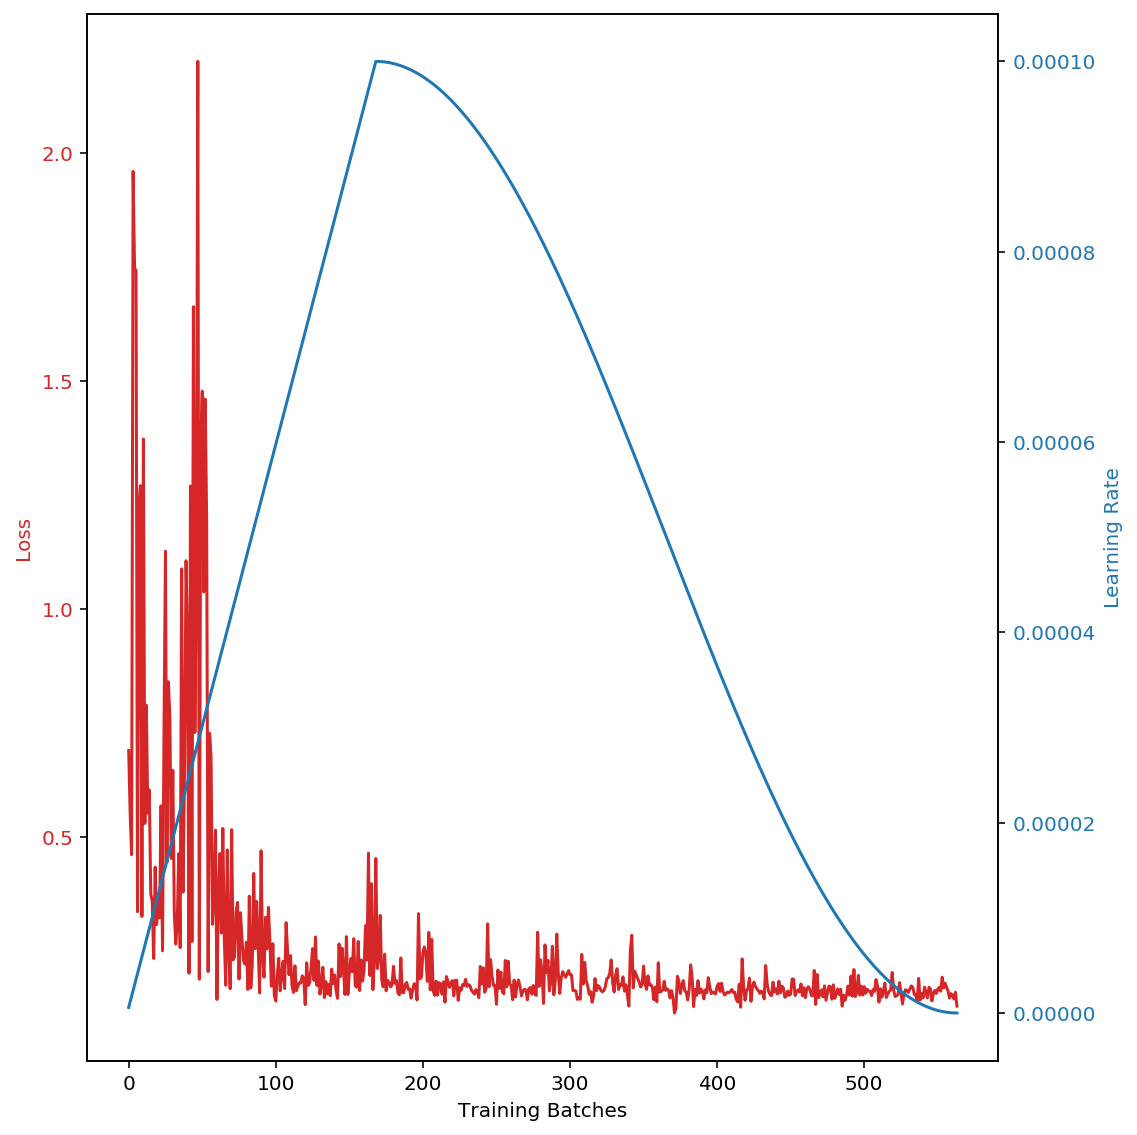

,id,proba,label
372,78936,0.454,0
994,79405,0.387,0
920,72415,0.507,1


In [6]:


batch_size = 32
epochs = 2

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=1,
    model_call_back=reg_sched,
    sampling_policy=None) # "without_replacement"

submission.to_csv("submission.csv", index=False)
submission.sample(3)


In [14]:
submission.sample(10)
submission.label.value_counts()

,id,proba,label
31,89432,0.428,0
555,37145,0.365,0
468,87924,0.515,1
829,97456,0.457,0
158,3146,0.481,0
202,27496,0.387,0
45,57932,0.542,1
587,71649,0.381,0
53,60345,0.392,0
903,51890,0.428,0


0    805
1    195
Name: label, dtype: int64

In [8]:


batch_size = 32
epochs = 7

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=1,
    model_call_back=reg_sched,
    sampling_policy=None) # "without_replacement"

submission.to_csv("submission2.csv", index=False)
submission.sample(3)


Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true
Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_h

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  722
Autocast =  True Epochs =  7 Divisor = 1 Examples = 9000 Batch Size =  32
Training Samples =  9000 Weighted Sampling =  False Num Batches =  282 Accumulation steps =  1



Epoch =  1 Loss = 0.332660 LR = 0.00004764



Epoch =  2 Loss = 0.177797 LR = 0.00009527



Epoch =  3 Loss = 0.166469 LR = 0.00009189



Epoch =  4 Loss = 0.161901 LR = 0.00006726


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

